## Setup

In [42]:
import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patheffects as effects
import networkx as nx
import os
from glob import glob
from tqdm.notebook import tqdm

In [3]:
def peek(df, top=3):
    print('Shape:', df.shape)
    return df.head(top)

## Read static content

### Zones list

In [9]:
zones = (pd.read_csv('geometry/jacksonville/block_groups/metro_centroid/jack_cbgs_centroid.txt')
         .assign(GEOID = lambda x: (x['GEOID'] + x['GEOID10']).astype(np.int64),
                 FID = lambda x: x['FID']+1)
         [['FID', 'GEOID']])
peek(zones)

Shape: (731, 2)


,FID,GEOID
0,1,121090204002
1,2,121099902000
2,3,120310161001


### Shelters list

In [11]:
shelts = (pd.read_csv('geometry/jacksonville/shelters/metro/jack_shelters.csv')
          .assign(FID = lambda x: -1*x['Id'])
          .astype({'GeoID': np.int64})
          .rename(columns={'GeoID': 'GEOID'})
          [['FID', 'GEOID']])
peek(shelts)

Shape: (55, 2)


,FID,GEOID
0,-1,120030401021
1,-2,120030401011
2,-3,120030401022


### Mapping between zone & CBG

In [13]:
# mapping between CBG/TAZ ID and Emmanuel's 7 destination choice zones
# (2 in city, 5 directional)
map_cbg_dir_zone = (pd.read_csv('geometry/jacksonville/zone-keys.csv')
                    .rename(columns={'DEST': 'em_zone', 'GEOID': 'cbg'}))
peek(map_cbg_dir_zone)

Shape: (730, 2)


,cbg,em_zone
0,121090204002,0
1,121099902000,0
2,120310161001,2


### Zones shapefile

In [16]:
zones_shp = (gp.read_file('geometry/jacksonville/block_groups/metro/jack_cbgs.shp')
             .fillna(0)
             .assign(cbg = lambda x: (x['GEOID'].astype(np.int64) +
                                      x['GEOID10'].astype(np.int64)),
                     aland = lambda x: x['ALAND'] + x['ALAND10'])
             [['cbg', 'aland', 'geometry']])
peek(zones_shp)

Shape: (731, 3)


,cbg,aland,geometry
0,121090204002,1839608.0,"POLYGON ((168736.999 614970.556, 168749.961 61..."
1,121099902000,0.0,"POLYGON ((163930.609 655963.945, 164320.076 65..."
2,120310161001,1197800.0,"POLYGON ((141199.142 659597.695, 141218.331 65..."


## Plot zones

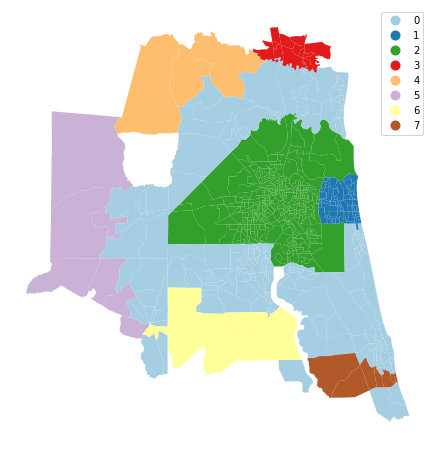

In [19]:
(zones_shp.merge(map_cbg_dir_zone)
 .query('aland > 0')
 .astype({'em_zone': 'category'})
 .plot(column='em_zone', figsize=(8, 8), cmap='Paired', legend=True))
plt.axis('off');

## Process demand file

In [20]:
def process_demand(fname, root='demand/Shen-scenarios',
                   zones=zones, shelts=shelts):
    """
    Read and process a demand CSV file.
    Convert the "long" demand format required by the simulator (where each
    pair of rows denotes one vehicle) to a wide format where each row denotes
    a vehicle and also includes whether the destination is a shelter.
    
    @param fname: <str> basename of the CSV file (without extension/directory)
    @param root: <str> folder containing the given file
    """
    # read the original demand file (should be CSV)
    raw = pd.read_csv(f'{root}/{fname}.csv')
    raw.columns = ['veh_id', 'GEOID', 'Departure']
    
    # get the set of 1st rows (contains info of origin) & map from TAZ to zone
    rows1 = (raw.iloc[::2]
             .merge(zones, on='GEOID')
             .rename(columns={'FID': 'orig', 'Departure': 'dep_time'})
             .drop(columns=['GEOID'])
            )
    # get the set of 2nd rows (contains info of destination & shelter)
    rows2 = raw.iloc[1::2].rename(columns={'Departure': 'is_shelter'})
    
    # separate the shelter and non-shelter vehicles & map from TAZ to zone
    shelt_rows = rows2.query('is_shelter == 1').merge(shelts, on='GEOID')
    zone_rows = rows2.query('is_shelter == 0').merge(zones, on='GEOID')
    
    # join them to get destination rows
    rows2 = (zone_rows.append(shelt_rows, ignore_index=True)
             .drop(columns=['GEOID'])
             .rename(columns={'FID': 'dest'})
            )
    # join them into 1 table
    demand = (pd.merge(rows1, rows2, on='veh_id')
              .sort_values('dep_time')
              .reset_index(drop=True)
             )
    # recreate vehicle IDs using the row numbers
    demand['veh_id'] = demand.index + 1
    
    return demand

In [33]:
base_dmd = process_demand('base-orig')
peek(base_dmd)

Shape: (453750, 5)


,veh_id,dep_time,orig,is_shelter,dest
0,1,1,649,0,141
1,2,1,452,0,145
2,3,1,178,0,326


### wide2long
Convert the prettified demand table format to the format usable by simulator

In [34]:
def wide2long(demand, outfile=None):
    """
    Convert the prettified wide format of the demand to long format (as
    provided by Shen) where each pair of rows denotes a vehicle.
    Optionally, also export the table as CSV.
    
    @param demand: <pd.df> prettified form of the demand
    @param outfile: <str> path of the output file (CSV); if None, do not export
    """
    # get the origin rows
    rows1 = (demand[['veh_id', 'orig', 'dep_time']]
             .rename(columns={'veh_id': 'ID', 'orig': 'FID',
                              'dep_time': 'Departure'}))
    # get the destination rows
    rows2 = (demand[['veh_id', 'dest', 'is_shelter']]
             .rename(columns={'veh_id': 'ID', 'dest': 'FID',
                              'is_shelter': 'Departure'}))
    # append them
    result = (rows1.append(rows2, ignore_index=True)
              .sort_values(['ID', 'Departure'], ascending=[True, False])
              .reset_index(drop=True))
    
    # export to CSV
    if outfile is not None:
        result.to_csv(outfile, index=False)
    
    return result

In [35]:
peek(wide2long(base_dmd))

Shape: (907500, 3)


,ID,FID,Departure
0,1,649,1
1,1,141,0
2,2,452,1


### Plot the hourly demand profile

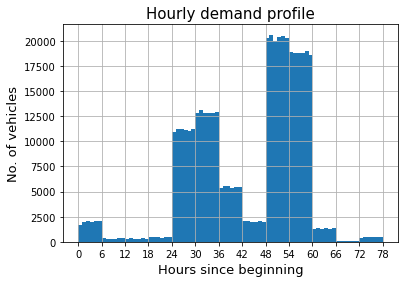

In [36]:
def plot_demand_profile(demand):
    (demand['dep_time']/60).hist(bins=78)
    plt.xticks(np.arange(0, 84, 6))
    plt.title('Hourly demand profile', fontsize=15)
    plt.xlabel('Hours since beginning', fontsize=13)
    plt.ylabel('No. of vehicles', fontsize=13)
    
plot_demand_profile(base_dmd)

### Rename the original demand files

### Process & export all demand scenarios

In [45]:
def process_scenarios(scenarios, out_dir='demand/Shen-scenarios', export=False):
    """
    Clean and prettify the demand of all of the given scenario names and store
    them in one table. Optionally also export these cleaned tables to their
    own files.
    @param scenarios: <[]> list of scenario names to be processed
    @param export: if true, export the cleaned table of each scenario with
    prefix 'clean'
    """
    # create combined demand table
    result = pd.DataFrame()
    
    # process all demand files and export their cleaned versions
    pbar = tqdm(scenarios)
    for scenario in pbar:
        pbar.set_description(f'Scenario: {scenario}')
        print(scenario)
        # read the demand in wide format
        dmd = process_demand(scenario)

        # add it to the overall demand table along with scenario name
        scenario = scenario.split('-')[0]
        sc_num = 0 if scenario == 'base' else int(scenario[1:])
        dmd.insert(0, 'scenario', sc_num)
        result = result.append(dmd, ignore_index=True)

        # convert to long format and export
        if export:
            wide2long(dmd, outfile=f'{out_dir}/{scenario}-clean.csv')
            
    # convert the data types to save space
    result = result.astype({'scenario': 'category', 'veh_id': np.int32,
                            'dep_time': np.int32, 'orig': np.int16,
                            'dest': np.int16, 'is_shelter': bool})
    return result

In [46]:
%%time
D = process_scenarios([f's{i}-orig' for i in range(1, 38)], export=False)

s1-orig
s2-orig
s3-orig
s4-orig
s5-orig
s6-orig
s7-orig
s8-orig
s9-orig
s10-orig
s11-orig
s12-orig
s13-orig
s14-orig
s15-orig
s16-orig
s17-orig
s18-orig
s19-orig
s20-orig
s21-orig
s22-orig
s23-orig
s24-orig
s25-orig
s26-orig
s27-orig
s28-orig
s29-orig
s30-orig
s31-orig
s32-orig
s33-orig
s34-orig
s35-orig
s36-orig
s37-orig

Wall time: 1min 54s


In [47]:
peek(D)

Shape: (16735556, 6)


,scenario,veh_id,dep_time,orig,is_shelter,dest
0,1,1,1,275,False,140
1,1,2,1,167,False,171
2,1,3,1,158,False,636


In [82]:
%%time
def compare_num_od(demand):
    """
    Compare the no. of OD pairs and total demand by scenario.
    """
    result = []
    for scenario, df in demand.groupby('scenario'):
        od_dmd = df.groupby(['orig', 'dest']).size().rename('nVeh')
        result.append({'scenario': scenario, 'num_ods': od_dmd.size,
                       'total_demand': od_dmd.sum()})
    result = pd.DataFrame(result).set_index('scenario')
    return result

odX = compare_num_od(D)
peek(odX)

Shape: (37, 2)
Wall time: 8.77 s


,num_ods,total_demand
scenario,,
1,85733,468704
2,89771,480609
3,80317,429783


In [84]:
odX.to_clipboard()

### Get OD matrix

In [49]:
# unique IDs of the zones and shelters combined;
# used to construct the OD matrix
zone_ids = zones.append(shelts, ignore_index=True)['FID'].sort_values().values
print(zone_ids.size)

786


### Get OD distribution (big zones)

Wall time: 35 s


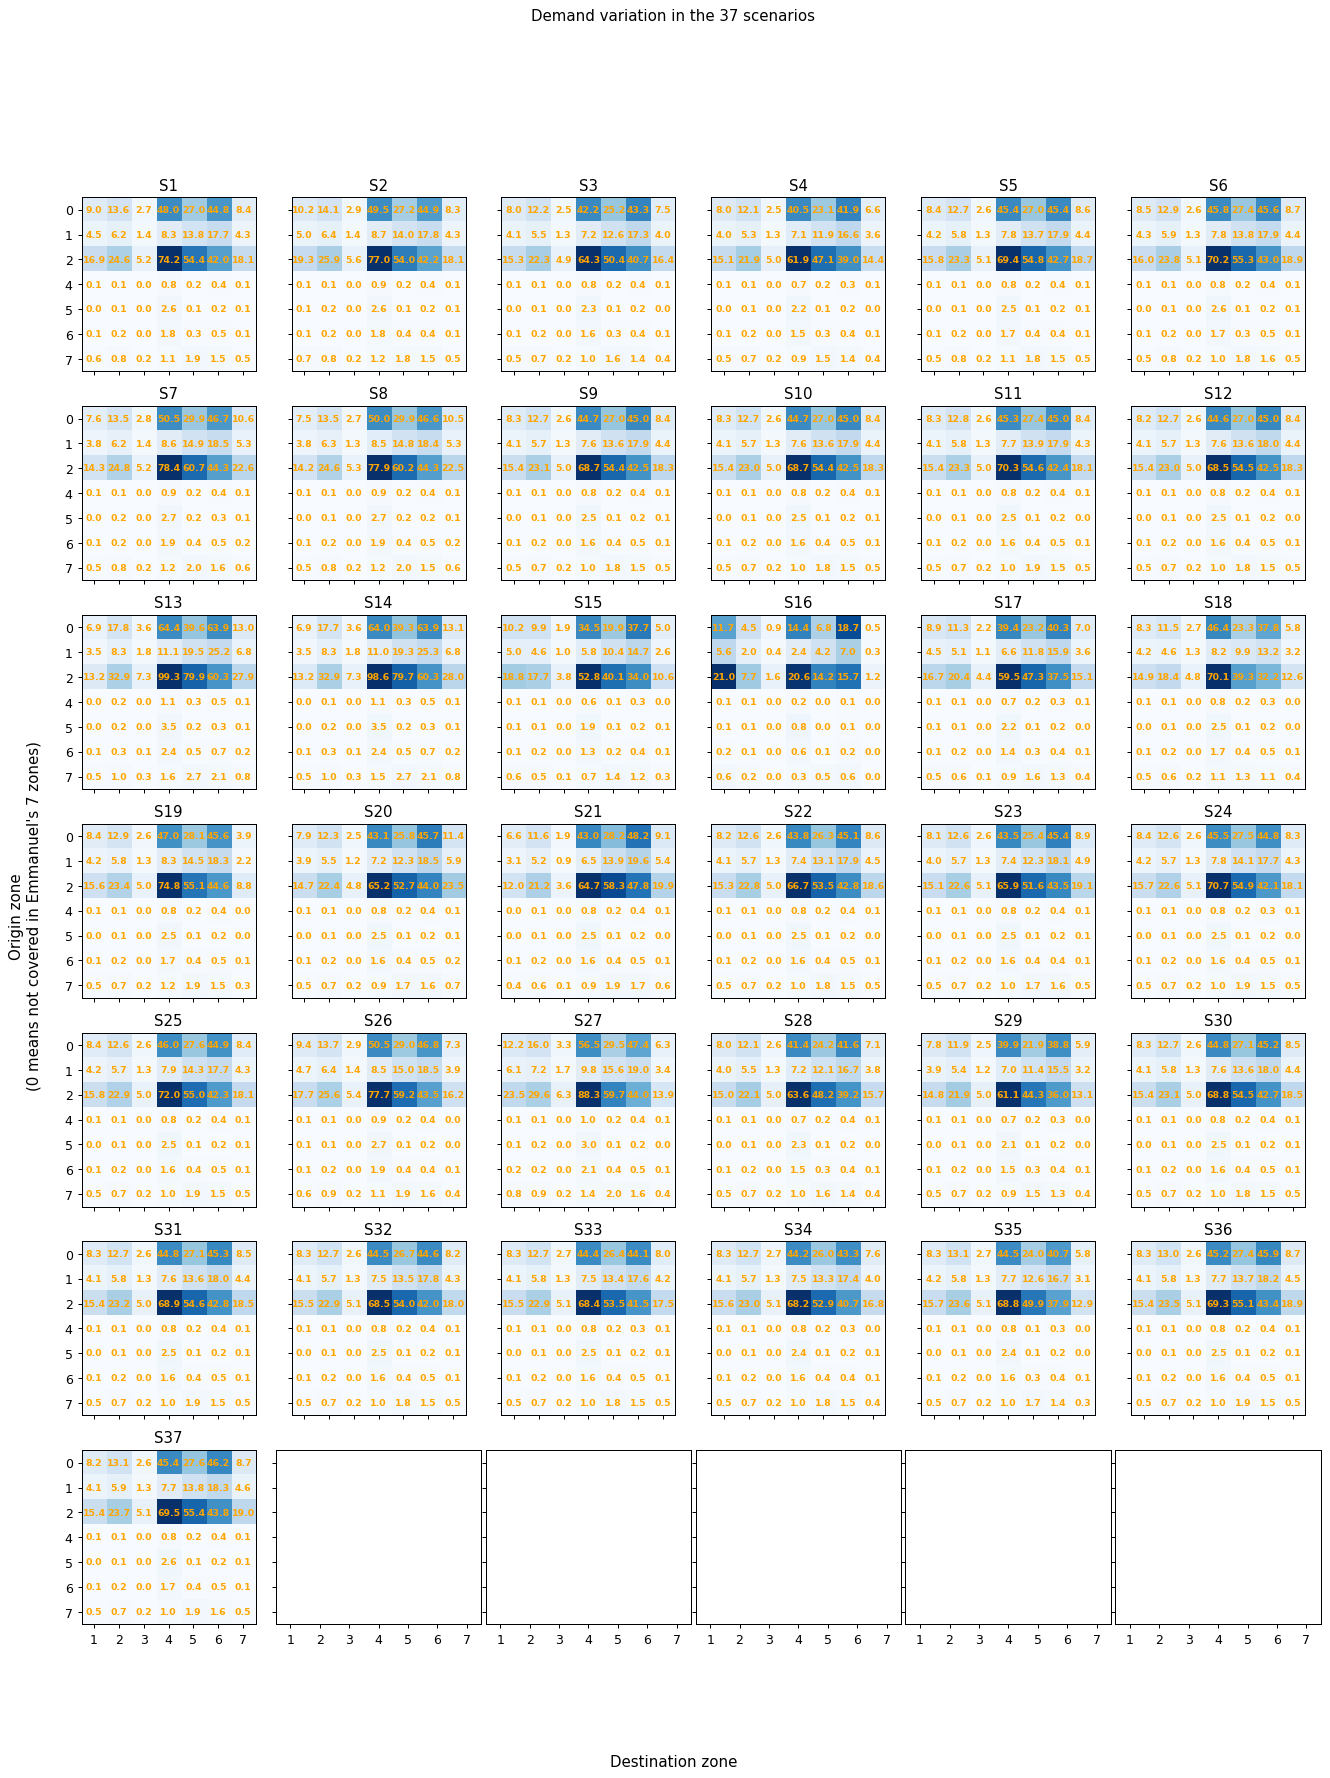

In [55]:
%%time
def plot_od_distr_big(D, zones=zones, map_cbg_dir_zone=map_cbg_dir_zone, plot_base=False):
    """
    Use the table containing the demand of all the scenarios and plot the
    histogram of the top few most popular OD pairs.
    """
    # get the mapping between destination zone IDs (FID) & directional zones
    dest_zone_to_em_zone = (map_cbg_dir_zone
                            .merge(zones.rename(columns={'GEOID': 'cbg'}), on='cbg')
                            .drop(columns=['cbg'])
                            .set_index('FID'))
    
    # convert the destination zones to directional zones
    res = (
        D.merge(dest_zone_to_em_zone, left_on='orig', right_index=True)
        .rename(columns={'em_zone': 'orig_zone'})
        .merge(dest_zone_to_em_zone, left_on='dest', right_index=True)
        .rename(columns={'em_zone': 'dest_zone'})
        .reset_index(drop=True)
        .astype({'scenario': int})
        [['scenario', 'veh_id', 'orig_zone', 'dest_zone', 'dep_time']])
    
    # plot
    if plot_base:
        pass
    else:
        ncol = 6
        nrow = -(-len(res.groupby('scenario')) // ncol)
        fig, axs = plt.subplots(nrow, ncol, figsize=(3*ncol, 3*nrow),
                                sharex=True, sharey=True, dpi=90)
        axs = axs.flatten()
        # skip the base scenario
        res = res.query('scenario != 0')
        for k, (scenario, df) in enumerate(res.groupby('scenario')):
            ax = axs[k]
            # get the demand table for this scenario
            dmd = (df.groupby(['orig_zone', 'dest_zone']).size()
                   .rename('nVeh').reset_index()
                   .pivot(index='orig_zone', columns='dest_zone', values='nVeh'))
            X = dmd.columns.astype(str)
            Y = dmd.index.astype(str)
            
            # plot the image
            ax.imshow(dmd.values, cmap='Blues')
            
            # plot the cell labels
            for i in range(len(X)):
                for j in range(len(Y)):
                    txt = ax.text(j, i, f'{dmd.iloc[i, j]/1e3:.1f}', color='orange',
                                  ha='center', va='center', fontsize=7.5, fontweight='bold')
                    # txt.set_path_effects(
                    #     [effects.withStroke(linewidth=2, foreground='w')])
            
            # format the labels & title
            ax.set_title(f'S{scenario}')
            ax.set_xticks(np.arange(0, len(X), 1))
            ax.set_yticks(np.arange(0, len(Y), 1))
            ax.set_xticklabels(X)
            ax.set_yticklabels(Y)
        fig.suptitle('Demand variation in the {} scenarios'
                  .format(len(res.groupby('scenario')), fontsize=15))
        fig.text(0.1, 0.5, "Origin zone\n(0 means not covered in Emmanuel's 7 zones)",
                 rotation=90, ha='center', va='center', fontsize=12)
        fig.text(0.5, 0.05, 'Destination zone', ha='center', fontsize=12)
        plt.subplots_adjust(wspace=0.02)

plot_od_distr_big(D)

### Get OD distribution
Plot the histogram of OD demand where x-axis is the OD ID and y-axis is the demand of that OD pair. Select only the top few most popular OD pairs across all the scenarios.

Wall time: 26.4 s


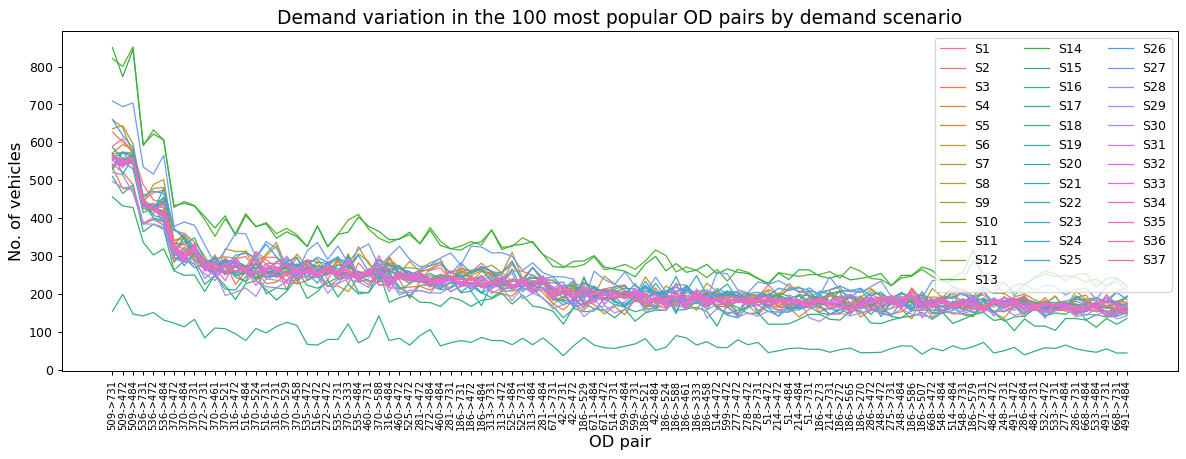

In [54]:
%%time
def plot_od_distr(D, top=100, figsize=(16, 5)):
    """
    Use the table containing the demand of all the scenarios and plot the
    histogram of the top few most popular OD pairs.
    """
    # get the list of all-scenario popular OD pairs
    pop_ods = (D.groupby(['orig', 'dest']).size().rename('nVeh')
               .sort_values(ascending=False).head(top)
               .reset_index()[['orig', 'dest']])
    
    # now filter these ODPs in all of the scenarios
    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    
    colors = sns.color_palette('husl', len(D.groupby('scenario')))
    
    for (scenario, df), color in zip(D.groupby('scenario'), colors):
        # get the demand table for this scenario
        dmd = df.groupby(['orig', 'dest']).size().rename('nVeh').reset_index()
        # filter only the popular ODPs
        dmd = dmd.merge(pop_ods, on=('orig', 'dest'), how='right')
        # format the OD pair labels
        dmd['od_id'] = dmd['orig'].astype(str) + '->' + dmd['dest'].astype(str)
        
        # plot the demand by ODP
        if scenario == 0: # special formatting for base scenario
            color, linewidth, sc_name = 'black', 3, 'Base'
        else:
            linewidth, sc_name = 1, f'S{scenario}'
        # calculate the total demand & no. of ODs in this scenario to be added to label
        od_dmd = D[D['scenario'] == scenario].groupby(['orig', 'dest']).size()
        label = sc_name
        
        ax.plot(dmd['od_id'], dmd['nVeh'], color=color, lw=linewidth, label=label)
        
        # format the xticks
        ticks_loc = ax.get_xticks()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_xticklabels(dmd['od_id'], rotation=90, fontsize=8)
    ax.legend(ncol=3)
    plt.title(f'Demand variation in the {top} most popular OD pairs by demand scenario',
              fontsize=15)
    plt.xlabel('OD pair', fontsize=13)
    plt.ylabel('No. of vehicles', fontsize=13)
    
plot_od_distr(D)

## Read simulation output

In [58]:
%%time
sim_out = (pd.concat(
    [pd.read_csv(f, usecols=range(8))
     .assign(scenario=int(os.path.basename(f).split('-')[2][1:]))
     for f in glob('../simulation_output/shen-strat2-v1/logger*.csv')])
           .assign(totalDistance = lambda x: x['totalDistance']/1609.34,
                   travelTime = lambda x: (x['endTime'] - x['startTime'])/12000)
           .astype({'vehicleID': np.int32, 'zoneType': 'category',
                   'startTime': np.int32, 'endTime': np.int32,
                   'originID': np.int16, 'destID': np.int16,
                   'visitedShelters': np.int32, 'scenario': 'category'}))
peek(sim_out)

Shape: (16271896, 10)
Wall time: 48.9 s


,vehicleID,zoneType,startTime,endTime,originID,destID,totalDistance,visitedShelters,scenario,travelTime
0,10,0,199,1106,75,75,2.200605,1,1,0.075583
1,113,0,799,1565,578,116,2.436083,1,1,0.063833
2,86,0,600,2101,158,557,5.298191,1,1,0.125083


In [59]:
sim_out.describe()

,vehicleID,startTime,endTime,originID,destID,totalDistance,visitedShelters,travelTime
count,1.627190e+07,1.627190e+07,1.627190e+07,1.627190e+07,1.627190e+07,1.627190e+07,1.627190e+07,1.627190e+07
mean,2.315780e+05,5.180442e+05,6.102094e+05,3.644450e+02,4.518307e+02,2.772105e+02,8.301496e+00,7.680428e+00
std,1.388568e+05,1.676055e+05,2.022828e+05,1.991554e+02,1.821180e+02,2.305721e+02,3.015758e+03,7.790689e+00
min,1.000000e+00,0.000000e+00,9.280000e+02,-5.600000e+01,-5.600000e+01,2.333710e-01,1.000000e+00,1.200000e-02
25%,1.130220e+05,3.836000e+05,4.583250e+05,1.950000e+02,3.330000e+02,1.139213e+02,1.000000e+00,2.263083e+00
50%,2.276320e+05,5.850000e+05,6.530060e+05,3.710000e+02,4.840000e+02,2.166572e+02,1.000000e+00,5.108333e+00
75%,3.439060e+05,6.528000e+05,7.498790e+05,5.270000e+02,5.650000e+02,3.687495e+02,1.000000e+00,1.051525e+01
max,6.375360e+05,9.359990e+05,1.216486e+06,7.160000e+02,7.310000e+02,2.568902e+03,2.423894e+06,9.625933e+01


In [90]:
sim_out.shape

(16271896, 10)

Wall time: 4.27 s


Text(0.5, 1.0, 'No. of visited shelters of top 250 vehicles in S1-12')

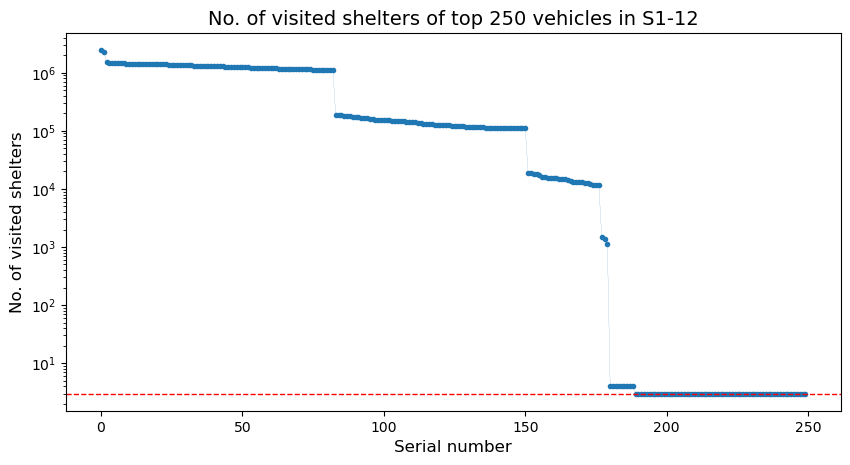

In [91]:
%%time
fig = plt.figure(dpi=100)
(sim_out.sort_values('visitedShelters', ascending=False)
 .head(250).visitedShelters.reset_index(drop=True)
 .plot(lw=0.1, marker='.', figsize=(10, 5)))
plt.yscale('log')
plt.axhline(3, color='red', ls='--', lw=1)
plt.ylabel('No. of visited shelters', fontsize=12)
plt.xlabel('Serial number', fontsize=12)
plt.title('No. of visited shelters of top 250 vehicles in S1-12', fontsize=14);

In [76]:
def compare_scenario_performance(data, yvar, ylabel, outliers=True):
    fig = plt.figure(figsize=(15, 6), dpi=100)
    ax = sns.boxplot(data=data, x='scenario', y=yvar, showfliers=outliers)
    fig.add_subplot(ax)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Demand scenario')

Wall time: 6.28 s


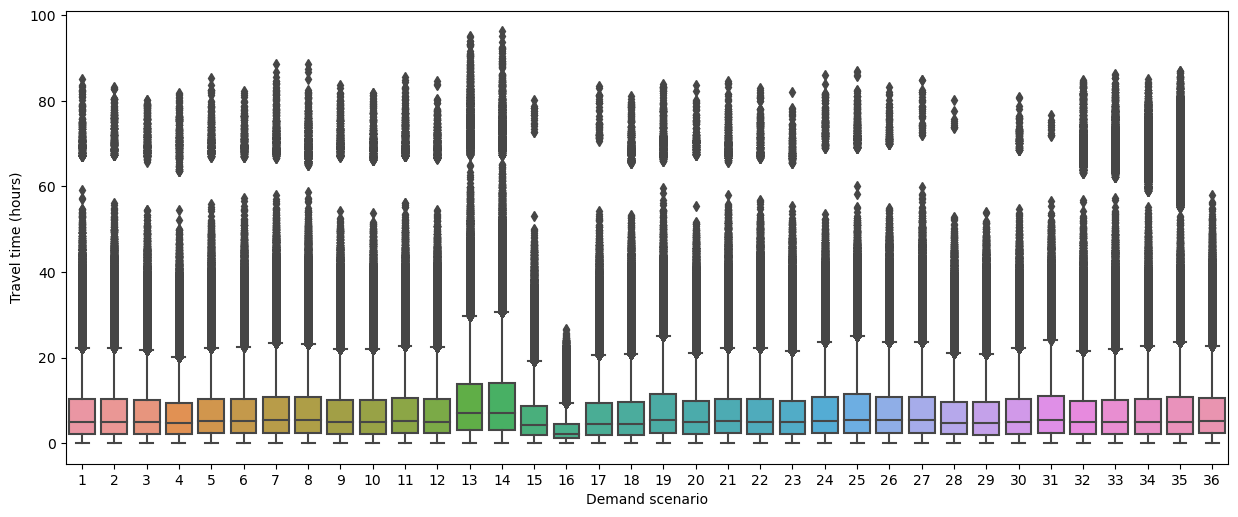

In [77]:
%time compare_scenario_performance(sim_out, 'travelTime', 'Travel time (hours)')

Wall time: 6.13 s


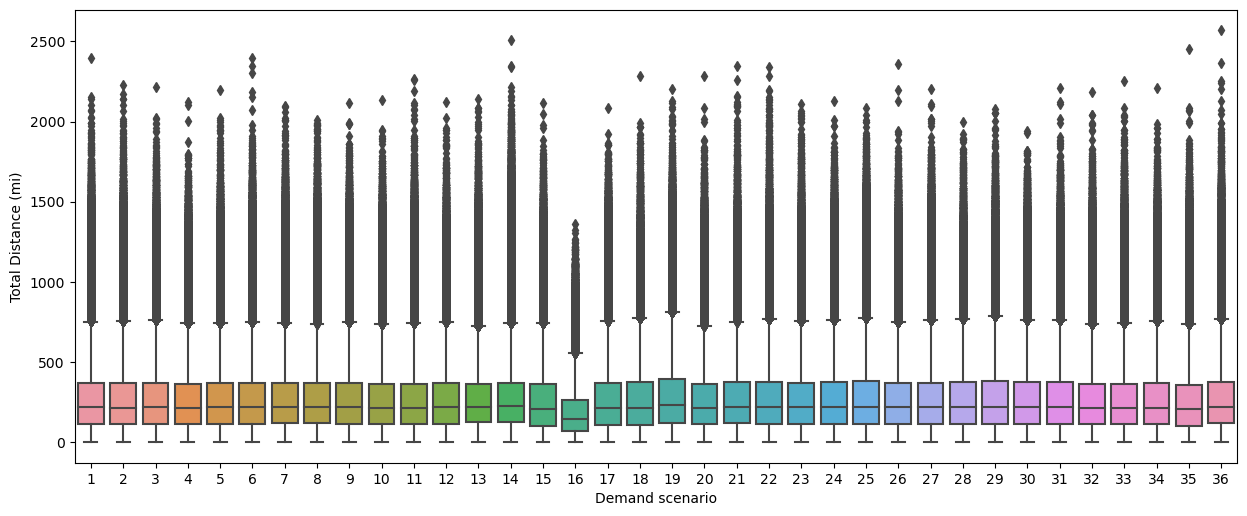

In [78]:
%time compare_scenario_performance(sim_out, 'totalDistance', 'Total Distance (mi)')

Wall time: 4.95 s


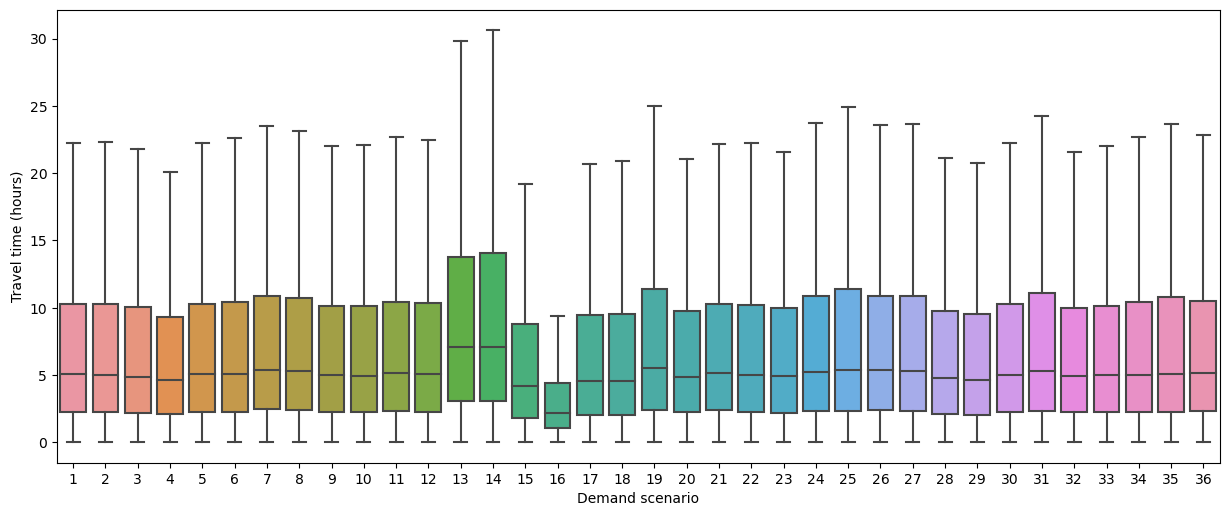

In [79]:
%time compare_scenario_performance(sim_out, 'travelTime', 'Travel time (hours)', outliers=False)

Wall time: 5.74 s


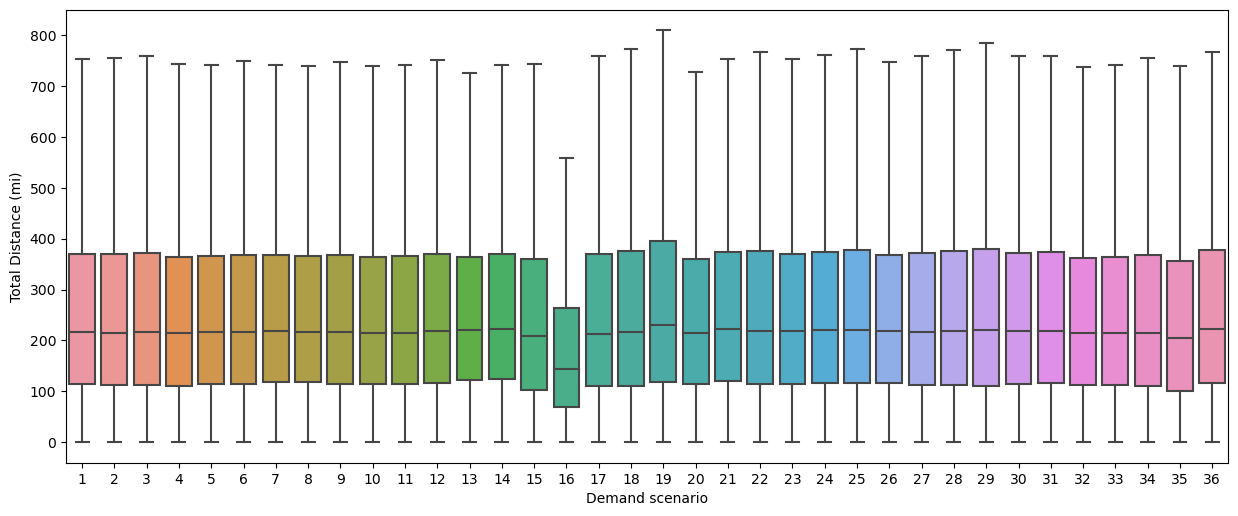

In [80]:
%time compare_scenario_performance(sim_out, 'totalDistance', 'Total Distance (mi)', outliers=False)

### By directional zone

In [66]:
%%time
def get_em_zone_output(data):
    """Assign the origin/dest directional zones to simulation output table."""
    fid2cbg = zones.append(shelts).rename(columns={'GEOID': 'cbg'})
    df = (data.merge(fid2cbg.rename(columns={'FID': 'originID'}),
                     on='originID', how='left')
          .merge(map_cbg_dir_zone.rename(columns={'em_zone': 'originZone'}),
                 on='cbg').drop(columns='cbg'))
    df = (df.merge(fid2cbg.rename(columns={'FID': 'destID'}),
                     on='destID', how='left')
          .merge(map_cbg_dir_zone.rename(columns={'em_zone': 'destZone'}),
                 on='cbg').drop(columns='cbg'))
    return df.astype({'originZone': 'category', 'destZone': 'category'})
    
sim_out_by_zone = get_em_zone_output(sim_out)
peek(sim_out_by_zone)

Shape: (16271896, 12)
Wall time: 54.5 s


,vehicleID,zoneType,startTime,endTime,originID,destID,totalDistance,visitedShelters,scenario,travelTime,originZone,destZone
0,10,0,199,1106,75,75,2.200605,1,1,0.075583,1,1
1,6709,0,47800,48507,75,75,2.187807,1,15,0.058917,1,1
2,23017,0,311000,311908,75,75,1.716262,1,16,0.075667,1,1


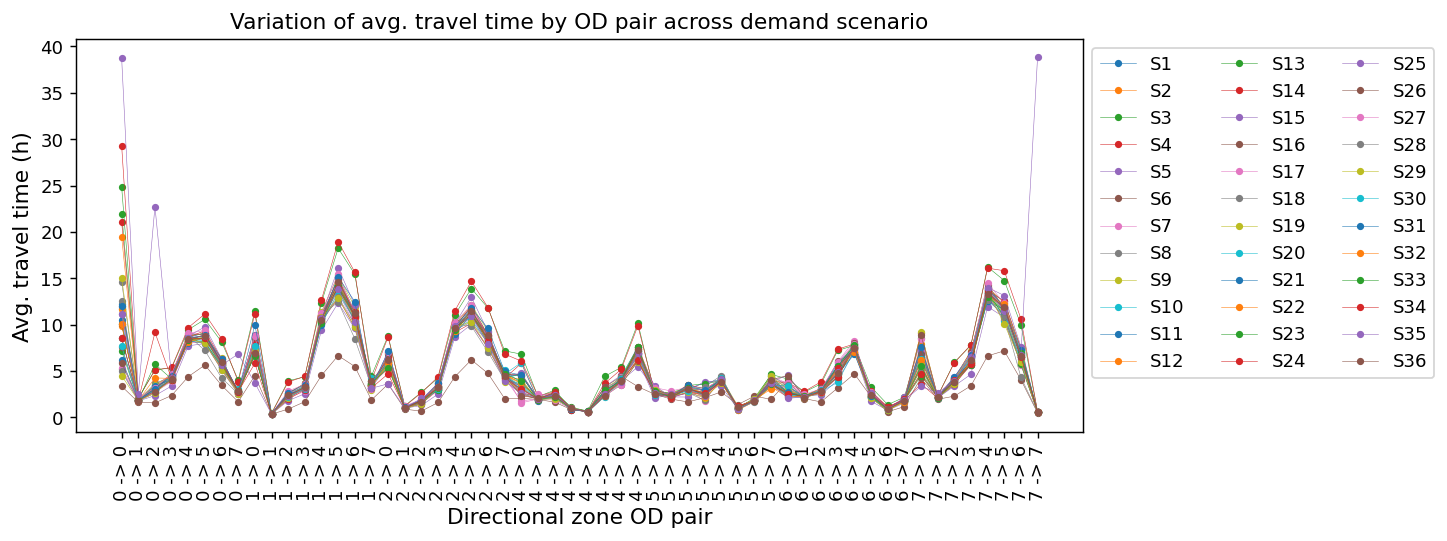

In [69]:
def compare_od_performance(data):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=130)
    for scenario, sc_df in data.groupby('scenario'):
        df = (sc_df.groupby(['originZone', 'destZone'])
              [['travelTime']].mean().reset_index()
              .assign(od_id = lambda x: x['originZone'].astype(str) +
                      ' -> ' + x['destZone'].astype(str))
              .sort_values('od_id')
              .assign(scenario = scenario))
        ax.plot(df['od_id'], df['travelTime'],
                label=f'S{scenario}', marker='.', lw=0.3)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1, 1), ncol=3)
    plt.ylabel('Avg. travel time (h)', fontsize=12)
    plt.xlabel('Directional zone OD pair', fontsize=12)
    plt.title('Variation of avg. travel time by OD pair across demand scenario')
    
compare_od_performance(sim_out_by_zone)

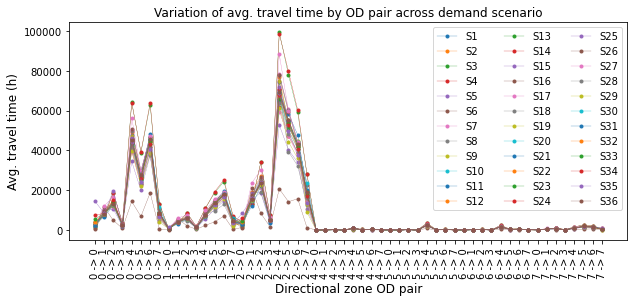

In [70]:
def compare_od_demand(data):
    fig, ax = plt.subplots(figsize=(10, 4))
    for scenario, sc_df in data.groupby('scenario'):
        df = (sc_df.groupby(['originZone', 'destZone'])
              .size().rename('demand').reset_index()
              .assign(od_id = lambda x: x['originZone'].astype(str) +
                      ' -> ' + x['destZone'].astype(str))
              .sort_values('od_id')
              .assign(scenario = scenario))
        ax.plot(df['od_id'], df['demand'],
                label=f'S{scenario}', marker='.', lw=0.3)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1, 1), ncol=3)
    plt.ylabel('Avg. travel time (h)', fontsize=12)
    plt.xlabel('Directional zone OD pair', fontsize=12)
    plt.title('Variation of avg. travel time by OD pair across demand scenario')
    
compare_od_demand(sim_out_by_zone)